# VAE Analysis - Faces dataset

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VariationalAutoEncoder import VariationalAutoEncoder
from utils.loaders import load_model, ImageLabelLoader

/home/comadan/.venv/gdl/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])


DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

## data

In [3]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])


In [4]:
att.head()

,Unnamed: 0,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


## architecture

In [5]:
vae = load_model(VariationalAutoEncoder, RUN_FOLDER)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



## reconstructing faces

Found 202599 validated image filenames.


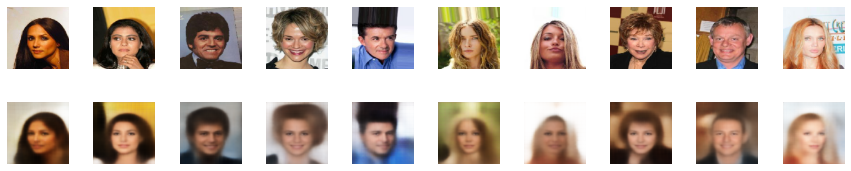

In [6]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = vae.encoder_model.predict(example_images)

reconst_images = vae.decoder_model.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)


## Latent space distribution

20/20 [==============================] - 0s 12ms/step


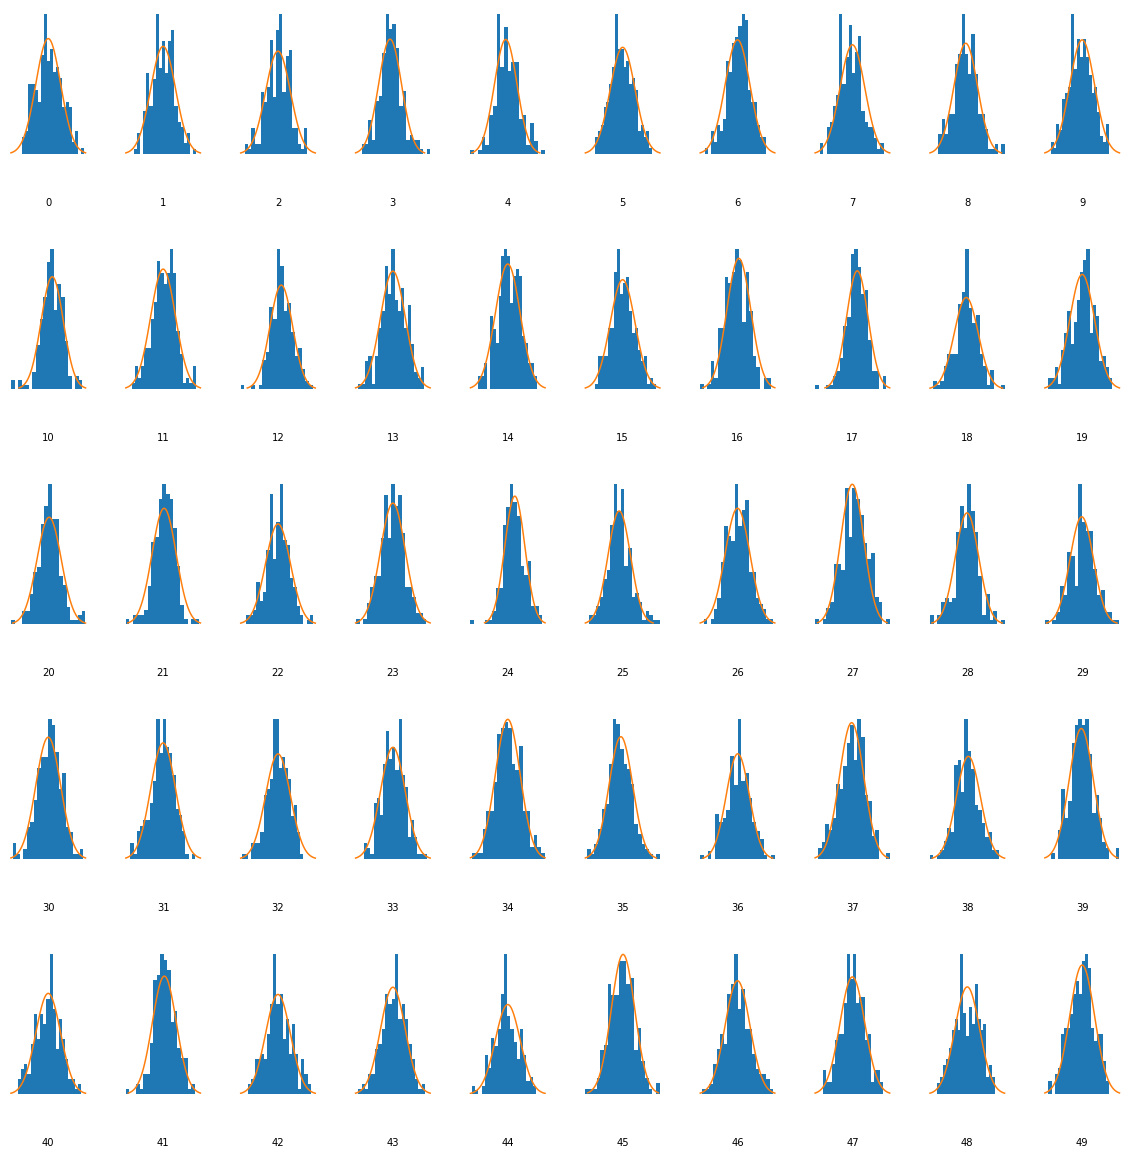

In [7]:
z_test = vae.encoder_model.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### Newly generated faces

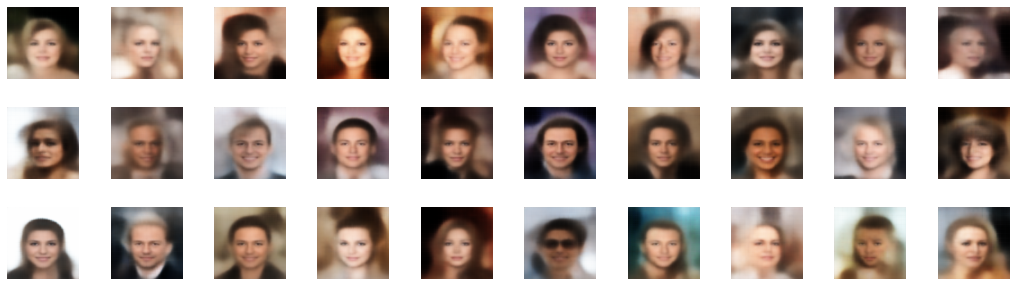

In [8]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,vae.latent_dim))

reconst = vae.decoder_model.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [9]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.latent_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.latent_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.latent_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.latent_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.latent_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.latent_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder_model.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


In [10]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder_model.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder_model.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()


In [11]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 202599 validated image filenames.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
238    : 1.038    : 1.003    : 1.6    : 1.6
490    : 0.691    : 0.612    : 1.253    : -0.347
754    : 0.363    : 0.331    : 1.203    : -0.049
1028    : 0.248    : 0.27    : 1.152    : -0.051
1313    : 0.208    : 0.205    : 1.106    : -0.046
1578    : 0.152    : 0.165    : 1.092    : -0.014
1846    : 0.135    : 0.136    : 1.085    : -0.007
2098    : 0.105    : 0.127    : 1.067    : -0.017
2359    : 0.103    : 0.113    : 1.061    : -0.006
2600    : 0.086    : 0.102    : 1.056    : -0.006
2816    : 0.082    : 0.096    : 1.033    : -0.023
3090    : 0.075    : 0.082    : 1.026    : -0.007
3361    : 0.071    : 0.066    : 1.028    : 0.002
3608    : 0.069    : 0.068    : 1.015    : -0.013
3872    : 0.058    : 0.064    : 1.01    : -0.004
4112    : 0.052    : 0.06    : 1.008    : -0.002
4366    : 0.054    : 0.057    : 1.002    : -0.007
4623    : 0.051    : 0.051    : 0.999    : -0.003
48

In [12]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
34    : 2.895    : 0.683    : 3.071    : 3.071
63    : 1.753    : 0.457    : 2.415    : -0.656
102    : 1.131    : 0.281    : 2.222    : -0.193
138    : 0.677    : 0.204    : 2.105    : -0.117
159    : 0.443    : 0.15    : 2.065    : -0.04
187    : 0.395    : 0.117    : 1.996    : -0.069
222    : 0.396    : 0.097    : 1.973    : -0.023
252    : 0.317    : 0.09    : 1.917    : -0.056
284    : 0.287    : 0.078    : 1.872    : -0.046
321    : 0.294    : 0.064    : 1.791    : -0.081
360    : 0.259    : 0.06    : 1.788    : -0.003
387    : 0.195    : 0.057    : 1.759    : -0.029
419    : 0.184    : 0.05    : 1.756    : -0.003
454    : 0.172    : 0.048    : 1.752    : -0.003
489    : 0.193    : 0.049    : 1.735    : -0.018
522    : 0.157    : 0.041    : 1.736    : 0.002
560    : 0.162    : 0.041    : 1.715    : -0.021
585    : 0.124    : 0.041    : 1.723    : 0.008
627    : 0.151    

In [13]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 validated image filenames.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
71    : 1.955    : 0.751    : 2.274    : 2.274
138    : 1.1    : 0.473    : 1.885    : -0.388
204    : 0.622    : 0.253    : 1.833    : -0.053
288    : 0.529    : 0.201    : 1.788    : -0.044
372    : 0.382    : 0.151    : 1.756    : -0.032
463    : 0.302    : 0.115    : 1.741    : -0.015
530    : 0.246    : 0.108    : 1.71    : -0.031
606    : 0.208    : 0.102    : 1.716    : 0.006
674    : 0.172    : 0.083    : 1.696    : -0.02
747    : 0.172    : 0.07    : 1.689    : -0.007
830    : 0.16    : 0.062    : 1.676    : -0.013
905    : 0.145    : 0.063    : 1.668    : -0.008
973    : 0.113    : 0.056    : 1.643    : -0.025
1045    : 0.108    : 0.053    : 1.622    : -0.021
1114    : 0.112    : 0.043    : 1.613    : -0.009
1184    : 0.104    : 0.047    : 1.62    : 0.007
1261    : 0.087    : 0.043    : 1.611    : -0.009
1327    : 0.088    : 0.043    : 1.607    : -0.004
1408    : 0.08

Eyeglasses Vector


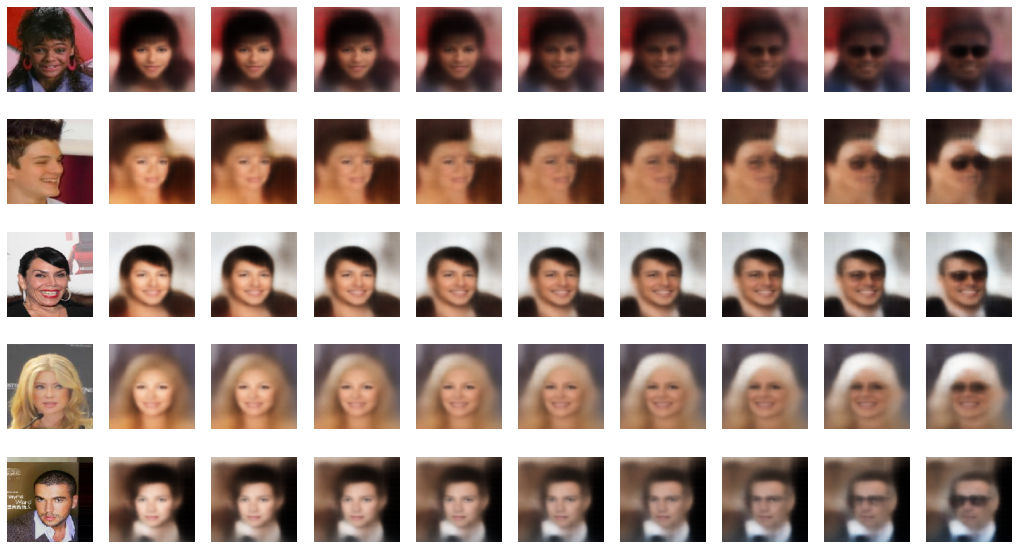

In [14]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

In [15]:

def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder_model.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder_model.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 validated image filenames.


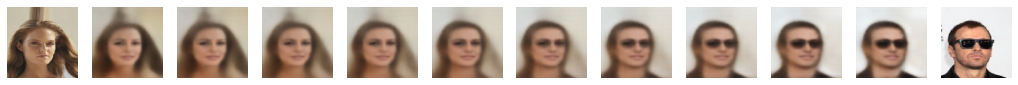

In [16]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


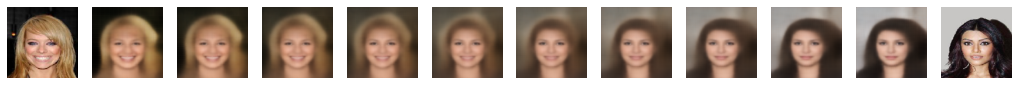

In [17]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


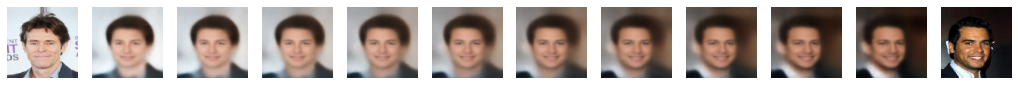

In [18]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)